In [9]:
# -*- encoding:urf-8 -*-
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table like and matrices
import pandas as pd
import numpy as np

# Modeling Helper
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno

# Configure visualization
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

train_path = '../input/train.csv'
test_path = '../input/test.csv'
hol_path = '../input/holiday.csv'
train_date_path = '../input/train_date.csv'
cache_path = '../input/cache/'
output_path = '../output/'
train_valid_path = '../input/validate/'
train_new_path = 'train_new_total_1.csv'
train_new = pd.read_csv(train_new_path)
test = pd.read_csv(test_path)
do_not_use_class = [1516,3005,3424]
train_new

,Class,parClass,SaleDate,saleCount,Coupon,holidayCluster,disHoliday,disHoliday_detail,month,dayOfWeek,...,wkDaySaleCount_mean,wkDaySaleCount_max,wkDaySaleCount_min,holDaySaleCount_median,holDaySaleCount_mean,holDaySaleCount_max,holDaySaleCount_min,wkHolRatio,classWeekdayRatio,parClassWeekdayRatio
0,1001,10,2015/1/1,3,0,3,1.0,1,1,3,...,9.033333,35,0,4,4.645161,15,0,3.737931,0.114993,0.119321
1,1001,10,2015/1/2,6,0,3,1.0,2,1,4,...,9.033333,35,0,4,4.645161,15,0,3.737931,0.084425,0.089765
2,1001,10,2015/1/3,7,0,3,1.0,3,1,5,...,9.033333,35,0,4,4.645161,15,0,3.737931,0.069869,0.072250
3,1001,10,2015/1/4,5,0,1,0.5,8,1,6,...,9.033333,35,0,4,4.645161,15,0,3.737931,0.120815,0.129174
4,1001,10,2015/1/5,9,0,1,0.3,9,1,0,...,9.033333,35,0,4,4.645161,15,0,3.737931,0.142649,0.141215
5,1001,10,2015/1/6,5,0,1,0.3,10,1,1,...,9.033333,35,0,4,4.645161,15,0,3.737931,0.147016,0.132458
6,1001,10,2015/1/7,28,0,1,0.0,0,1,2,...,9.033333,35,0,4,4.645161,15,0,3.737931,0.318777,0.315271
7,1001,10,2015/1/8,7,0,1,0.0,0,1,3,...,9.033333,35,0,4,4.645161,15,0,3.737931,0.114993,0.119321
8,1001,10,2015/1/9,4,0,1,0.0,0,1,4,...,9.033333,35,0,4,4.645161,15,0,3.737931,0.084425,0.089765
9,1001,10,2015/1/10,4,0,2,0.0,0,1,5,...,9.033333,35,0,4,4.645161,15,0,3.737931,0.069869,0.072250


#### Helper Functions

In [2]:
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def exclude_abnormal_value(train):
    # best 2 mean 1.5 std
    step = 14   # past one week
    train.loc[:,'count'] = range(0,train.shape[0])
    train['count'] = train['count'] % (train[train['Class'] == 3016].shape[0])
#     print train['count']
    train['count'] = (train['count'] / step).astype('int')
    coord = train.groupby(['Class','count'],as_index=False)['saleCount'].agg({'mean':'mean'})
    train = pd.merge(train, coord, on=['Class','count'],how='left')
    coord = train.groupby(['Class','count'],as_index=False)['saleCount'].agg({'std':'std'})
    train = pd.merge(train, coord, on=['Class','count'],how='left')
    train['mean'] = train.groupby('Class')['mean'].shift(step)
    train['std'] = train.groupby('Class')['std'].shift(step)
    train['mean'].fillna(method='bfill',inplace=True)
    train['std'].fillna(method='bfill',inplace=True)
    train.loc[:,'saleCount_min'] = train['mean'] - 2 * train['std']
    train.loc[:,'saleCount_max'] = train['mean'] + 2 * train['std']
    train['saleCount_max'] = np.ceil(train['saleCount_max'])
    max_bool = train['saleCount_max'] < train['saleCount']
    train['saleCount'][max_bool] = train['saleCount_max'][max_bool]
    neg_bool = train['saleCount_min'] < 0
    train['saleCount_min'][neg_bool] = 0
    min_bool = train['saleCount_min'] > train['saleCount']
    train['saleCount'][min_bool] = train['saleCount_min'][min_bool]
    train['saleCount'] = np.ceil(train['saleCount'])
    del train['saleCount_min'],train['saleCount_max'],train['std'],train['mean'],train['count']
    return train

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
step = 14
train_12 = train_new[train_new['Class'] == 3016]
train12_tr = train_12[train_12['SaleDate']<'2015-05-01'].reset_index()
# train12_te = train_12[train_12['SaleDate'] >= '2015-04-01'].reset_index()
# 指数平滑
expwighted_avg = pd.ewma(train12_tr['saleCount'], halflife= 7)
# 排除异常值
train12_exc = exclude_abnormal_value(train12_tr)
train12_lob_exc = np.log(train12_exc['saleCount'])
# 趋势
decomposition = seasonal_decompose(train12_tr['saleCount'].values,freq = step)
trend = decomposition.trend
plt.plot(trend,color = 'blue',label='trend')
plt.plot(train12_exc['saleCount'],color = 'black',label='exclude abnormal value')
plt.plot(train12_tr['saleCount'],label='before excluding')
plt.plot(expwighted_avg,color='green',label='expotienal smooth')
plt.legend(loc='best')
plt.title('Class 12')
plt.show(block=False)

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
train12_exc[['SaleDate','saleCount']].set_index('SaleDate').plot()

节日第一天与节前三天对销量的影响

In [11]:
train_12 = train_new[train_new['Class'] == 12]
train12_tr = train_12[train_12['SaleDate']<'2015-05-01'].reset_index()
train_12

,Class,parClass,SaleDate,saleCount,Coupon,holidayCluster,disHoliday,disHoliday_detail,month,dayOfWeek,...,wkDaySaleCount_mean,wkDaySaleCount_max,wkDaySaleCount_min,holDaySaleCount_median,holDaySaleCount_mean,holDaySaleCount_max,holDaySaleCount_min,wkHolRatio,classWeekdayRatio,parClassWeekdayRatio
16380,12,12,2015/1/1,103,0,3,1.0,1,1,3,...,127.5,222,0,107,99.032258,197,0,2.491045,0.126014,0.126020
16381,12,12,2015/1/2,99,0,3,1.0,2,1,4,...,127.5,222,0,107,99.032258,197,0,2.491045,0.120698,0.120703
16382,12,12,2015/1/3,80,0,3,1.0,3,1,5,...,127.5,222,0,107,99.032258,197,0,2.491045,0.116221,0.116226
16383,12,12,2015/1/4,107,0,1,0.5,8,1,6,...,127.5,222,0,107,99.032258,197,0,2.491045,0.133197,0.133203
16384,12,12,2015/1/5,161,0,1,0.3,9,1,0,...,127.5,222,0,107,99.032258,197,0,2.491045,0.176290,0.176298
16385,12,12,2015/1/6,146,0,1,0.3,10,1,1,...,127.5,222,0,107,99.032258,197,0,2.491045,0.140099,0.140105
16386,12,12,2015/1/7,144,0,1,0.0,0,1,2,...,127.5,222,0,107,99.032258,197,0,2.491045,0.187389,0.187398
16387,12,12,2015/1/8,129,0,1,0.0,0,1,3,...,127.5,222,0,107,99.032258,197,0,2.491045,0.126014,0.126020
16388,12,12,2015/1/9,104,0,1,0.0,0,1,4,...,127.5,222,0,107,99.032258,197,0,2.491045,0.120698,0.120703
16389,12,12,2015/1/10,97,0,2,0.0,0,1,5,...,127.5,222,0,107,99.032258,197,0,2.491045,0.116221,0.116226


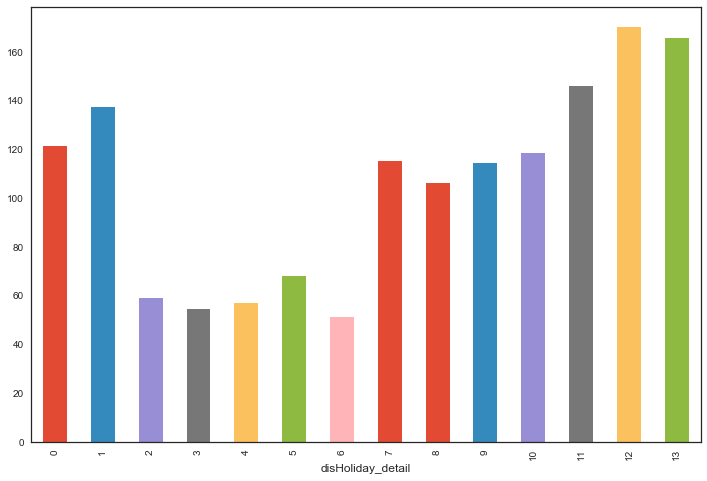

In [12]:
train_12.groupby('disHoliday_detail')['saleCount'].mean().plot(kind='bar')

In [15]:
train_12.groupby('disWorkday_detail')['saleCount'].mean().plot(kind='bar')

KeyError: 'disWorkday_detail'

In [ ]:
coord = train_new[train_new['disHoliday_detail'] == 0].groupby(['Class','disHoliday_detail'],as_index=False)['saleCount'].mean()
coord.fillna(0.01,inplace=True)

In [ ]:
train12_tr.groupby('weekOfYear')['saleCount'].sum().plot()
train12_tr.groupby('weekOfYear')['saleCount'].sum().diff(1).plot()

In [ ]:
train12_exc.groupby('month')['saleCount'].sum().plot()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train12_exc['saleCount'].values,freq = 7)
trend = decomposition.trend
plt.plot(trend)

In [ ]:
lastWeeksSaleCount = train12_exc.groupby(['Class','weekOfYear'],as_index=False)['saleCount'].agg({'weekSaleCount':'sum'})
# lastWeeksSaleCount['lastWeekSaleCount'] = lastWeeksSaleCount['weekSaleCount'].shift(1)
# lastWeeksSaleCount.fillna(method='bfill',inplace=True)
# lastWeeksSaleCount['last2WeekSaleCount'] = lastWeeksSaleCount['lastWeekSaleCount'].shift(1)
# lastWeeksSaleCount.fillna(method='bfill',inplace=True)
# lastWeeksSaleCount['last3WeekSaleCount'] = lastWeeksSaleCount['last2WeekSaleCount'].shift(1)
# lastWeeksSaleCount.fillna(method='bfill',inplace=True)
# lastWeeksSaleCount['last4WeekSaleCount'] = lastWeeksSaleCount['last3WeekSaleCount'].shift(1)
# lastWeeksSaleCount.fillna(method='bfill',inplace=True)
lastWeeksSaleCount.loc[:,'lastWeekdiff'] = lastWeeksSaleCount['weekSaleCount'].diff(1)
lastWeeksSaleCount.loc[:,'last2Weekdiff'] = lastWeeksSaleCount['weekSaleCount'].diff(2)
lastWeeksSaleCount.loc[:,'last3Weekdiff'] = lastWeeksSaleCount['weekSaleCount'].diff(3)
lastWeeksSaleCount.loc[:,'last3Weekdiff'] = lastWeeksSaleCount['weekSaleCount'].diff(4)
lastWeeksSaleCount

## 训练